## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. Some of these scam e-mails have some offensive content. I don't think anything is worse than R-rated, but I just want to warn you that if you start reading the e-mail text, you might read something offensive. If that's a problem, feel free to e-mail me and we can talk about it more or you can skip the assignment.  

### Q1.

Open the `Phishing_Email.parquet` data. It is available at `https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet`, and you can download it directly using Pandas by providing that URL: `df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')`.

We just want to look at the first step of cleaning text data, so you can get an idea of how it works. The `Email Text` variable contains the actual text of the email and the `Email Type` takes the value `Phishing Email` or `Safe Email`. We want to predict which emails are phishing emails from their contents.

Use the `str.split()` method to break the `Phishing Email` values into **tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens. Print the results of your split and examine it.

In words, how would you clean the tokens and use them to predict whether the email is a phishing scam or not? A short summary of the kinds of tasks you would do and how you would run a predictive algorithm is fine.

I would remove useless words like 'the', 'and', etc... and then divide the emails into known scams and known legit emails. I would limit the total number of tokens to something manageable, meaning not like 100,000 different words. My instinct is to use a random forest to split the emails by word presence into more likely to be scam or more likely to be legit. I am imagining a tree where if a certain word is present the chance it is a scam is x, and nodes just continue like that for a reasonable depth. I would train the model on maybe 60% of the data then test it on the remaining 40%.

In [2]:
import pandas as pd
import pickle
df = pd.read_parquet('https://data434.s3.us-east-2.amazonaws.com/Phishing_Email.parquet')
df.head()

,index,Unnamed: 0,Email Text,Email Type
0,0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [5]:
tokens = df['Email Text'].str.split()


### Q2.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [6]:

with open('all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens. What do you notice about the frequency of occurrence of different tokens? How does it look?

<Axes: ylabel='Frequency'>

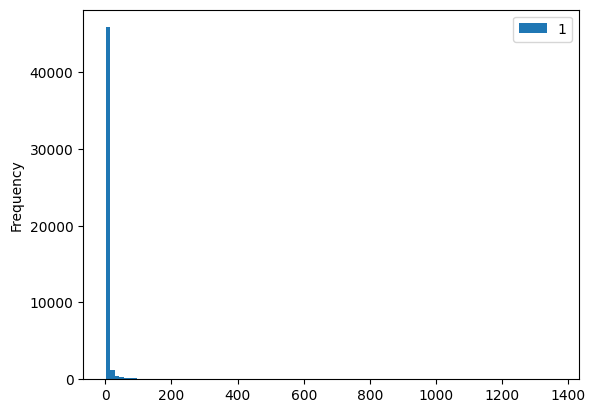

In [8]:
plot = pd.DataFrame(token_freq)
plot.plot.hist(grid=False,bins=100)

Most words appear only once or a very few number of times.

### Q3.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [10]:
df = pd.read_parquet('/content/Phishing_clean.parquet')
df.head()

,Email Type,new,date,get,please,enron,like,2002,would,one,...,ï¿½ï¿½,safety,yap,ypil,maintain,procedures,tip,elizabeth,leadership,italian
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
X = df.drop(['Email Type'], axis=1)
y = df['Email Type']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=125)


In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
model = LinearRegression(fit_intercept=False).fit(X_train, y_train)

y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)
print('train: ', r2_score(y_hat_train,y_train) )
print('test: ', r2_score(y_hat_test,y_test) )

train:  0.6210107280960204
test:  -0.00026838432670373


R squared for the training is .62 and -0.0002 for the test. Don't love the look of that.

In [16]:
cdf = pd.DataFrame({'variable':model.feature_names_in_ , 'value':model.coef_})
cdf['abs'] = np.abs(cdf['value'])
cdf.sort_values('abs',ascending=False)

,variable,value,abs
710,1997,-1.415784e+13,1.415784e+13
421,1995,1.158467e+13,1.158467e+13
1133,"19,",-1.025713e+13,1.025713e+13
340,2005,-9.773947e+12,9.773947e+12
1146,-0400,-8.062341e+12,8.062341e+12
...,...,...,...
1399,union,2.822876e-04,2.822876e-04
565,east,-2.746582e-04,2.746582e-04
2268,ravages,-1.068115e-04,1.068115e-04
457,due,-6.484985e-05,6.484985e-05


According to this numbers have the highest absolute value and most strongly influence predictions.

### Q4.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

<Axes: >

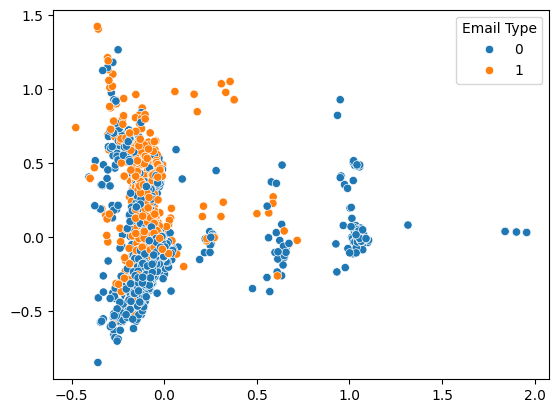

In [18]:
import seaborn as sns
from sklearn.decomposition import PCA
reduction = PCA(n_components=2).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)
sns.scatterplot(x=Z_test[:,0],y=Z_test[:,1],hue=y_test)

Scam emails do not go far out on the x axis will real eamils may have more balanced components.

### Q5.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [19]:
reduction = PCA(n_components=2610).fit(X_train)
Z_train = reduction.transform(X_train)
Z_test = reduction.transform(X_test)

lm_pca = LinearRegression().fit(Z_train,y_train)
y_hat_test = lm_pca.predict(Z_test)
y_hat_train = lm_pca.predict(Z_train)

print('Train r2: ', r2_score(y_hat_train,y_train) )
print('Test r2: ', r2_score(y_hat_test,y_test) )

Train r2:  0.692897536096375
Test r2:  0.5873905973217184


This performance is much better and does not over fit the training data.

### Q6.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

The original data has many words and some that may only appear in it. Because of this the model can be picky and make predictions based on words thtat only appear a few times. By using PCA the number of components the model can use are reduced so there's is less of an oppurtunity to overfit the data in the training phase.